In [1]:
figpath = '/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/Revision/figures'

## Import required modules

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import session_info
session_info.show()

In [4]:
# import a module given the full path?
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/ver8regions_torepo/ROIenrichment.py")
ROIenrichment = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = ROIenrichment
spec.loader.exec_module(ROIenrichment)

spec = importlib.util.spec_from_file_location("module.name", "/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/ver8regions_torepo/_utils.py")
_utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = _utils
spec.loader.exec_module(_utils)

In [14]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200)

## Prepare functions

## Read in anndata

In [6]:
# still need to confirm AVN_transition!!

adata_vis = _utils.read_visium('/nfs/team205/heart/anndata_objects/8regions/visium-OCT_adult-8reg-revision_raw.h5ad',
                               lognorm=True, cellname_convert=False)
adata_vis

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


AnnData object with n_obs × n_vars = 93788 × 23532
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'annotation_JC', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'region_cell2loc', 'annotation_final', 'Adip1', 'Adip2', 'Adip3', 'B', 'B_plasma', 'CD14+Mo', 'CD16+Mo', 'CD4+T_act', 'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans', 'DC', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap', 'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_endocardial', 'EC8_ln', 'FB1', 'FB2', 'FB3', 'FB4_activated', 'FB5', 'FB6', 'ILC', 'LYVE1+IGF1+MP', 'LYVE1+MP_cycling', 'LYVE1+TIMD4+MP', 'MAIT-like', 'Mast', 'Meso', 'MoMP', 

In [7]:
category_name='annotation_final'

In [8]:
pd.crosstab(adata_vis.obs['donor'],adata_vis.obs['region'])

region,AVN,AX,LA,LV,RA,RV,SAN,SP
donor,,,,,,,,
A61,10278,0,0,0,0,0,0,0
AH1,2807,0,0,0,0,0,4243,2843
AH2,7999,0,0,0,0,0,3802,0
AH5,0,0,0,0,0,0,12781,0
AH6,2942,0,0,0,0,0,0,0
AV14,0,0,0,0,0,0,6282,0
D3,0,0,0,0,0,2562,0,2199
D5,0,2177,2871,2891,2955,1225,0,3601
D6,0,2152,1249,4333,1035,1252,0,0


## Each region, each structure

In [41]:
def plot_ROIenrichment_bar(adata_vis, 
                           region,
                           roi,
                           category_name,
                           groupby='region',
                           filtering = 'rank_pos',  # select from 'rank_pos','pval_pos','rank_both','pval_both'
                           n_rank = 10,
                           p_adj_thresh = 0.05,
                           figsize = (3,3),
                           title = None,
                           title_fontsize = 20,
                           legend_fontsize = 10,
                           bbox_to_anchor = (2,1),
                           save_fig = False
                          ):
    
    adata = adata_vis[adata_vis.obs['region']==region]
    
    # select groups which has the roi
    _df = pd.crosstab(adata.obs[groupby],adata.obs[category_name])
    _df = _df[roi]
    groups = list(_df.index[_df>0])
    
    if len(groups) == 1:
        
        grp = groups[0]
        slide = adata[adata.obs[groupby]==grp]

        # remove prop-cellstates which doesn't exist in the region
        rm_list = [x for x in np.sum(slide.obs)[np.sum(slide.obs)==0].index if 'prop_' in x]
        slide.obs.drop(rm_list, axis=1, inplace=True)

        # ROI enrichment calculation
        res=ROIenrichment.ROI_enrichment_allcomparison(slide,roi=roi,category_name=category_name)
        res=res.sort_values('logOR',ascending=False)

        if filtering=='rank_pos':
            res = res[:n_rank].copy()
        elif filtering=='pval_pos':
            res=res[(res['p_adj']<p_adj_thresh)&(res['logOR']>0)]
        else:
            if filtering!=None:
                raise KeyError('invalid <filtering>')

        # plotting
        plt.rcParams["figure.dpi"] = 200
        # hide grid
        plt.rcParams['axes.grid'] = False
        plt.figure(figsize=figsize)
        color = ['#870052' if x<p_adj_thresh else 'grey' for x in res['p_adj']]
        plt.bar(res['cell'], res['logOR'], yerr=res['ebar'], color=color)
        if title!=None:
            plt.title(title, fontdict={'fontsize':title_fontsize})
        else:
            plt.title(f'{grp}, {roi}', fontdict={'fontsize':title_fontsize})
        plt.ylabel('logOR')
        plt.xticks(rotation= 90)
        plt.legend(handles=[plt.Rectangle((0,0),1,1, color='#870052')],
                   labels=['p_adj < '+str(p_adj_thresh)],
                   fontsize=legend_fontsize)

        plt.margins(x=0.03)
        if save_fig:
            plt.savefig(f'{figpath}/{region}_{roi}_roienrich_perdonor.pdf')
        plt.show()
        
    elif len(groups) > 1:
    
        # plotting
        plt.rcParams["figure.dpi"] = 200
        # hide grid
        plt.rcParams['axes.grid'] = False
        fig, axs = plt.subplots(nrows=1, ncols=len(groups), figsize=figsize)
        fig.autofmt_xdate(rotation=90, ha='center')
    
        for i,grp in enumerate(groups):
            
            slide = adata[adata.obs[groupby]==grp]
            
            n_spots_in_roi = len(slide[slide.obs[category_name]==roi])
            if n_spots_in_roi == 0:
                continue
            
            # remove prop-cellstates which doesn't exist in the region
            rm_list = [x for x in np.sum(slide.obs)[np.sum(slide.obs)==0].index if 'prop_' in x]
            slide.obs.drop(rm_list, axis=1, inplace=True)

            # ROI enrichment calculation
            res=ROIenrichment.ROI_enrichment_allcomparison(slide,roi=roi,category_name=category_name)
            res=res.sort_values('logOR',ascending=False)

            if filtering=='rank_pos':
                res=res[:n_rank].copy()
            elif filtering=='pval_pos':
                res=res[(res['p_adj']<p_adj_thresh)&(res['logOR']>0)]
            else:
                if filtering!=None:
                    raise KeyError('invalid <filtering>')
                    
            color = ['#870052' if x<p_adj_thresh else 'grey' for x in res['p_adj']]
            axs[i].bar(res['cell'], res['logOR'], yerr=res['ebar'], color=color)
            axs[i].set_title(f'{grp}', fontdict={'fontsize':title_fontsize})
            axs[i].set_ylabel('logOR')
            axs[i].margins(x=0.03)
            
            if i==0:
                if title!=None:
                    fig.suptitle(title, fontsize=title_fontsize)
                else:
                    fig.suptitle(roi, fontsize=title_fontsize)
            if i==(len(groups)-1):
                plt.legend(handles=[plt.Rectangle((0,0),1,1, color='#870052')],
                           labels=['p_adj < '+str(p_adj_thresh)],
                           fontsize=legend_fontsize, bbox_to_anchor=bbox_to_anchor)
            
            del slide,res,color 
        
        plt.tight_layout()
        if save_fig:
            plt.savefig(f'{figpath}/{region}_{roi}_roienrich_perdonor.pdf')
        plt.show()

In [10]:
pd.crosstab(adata_vis.obs['region'],adata_vis.obs[category_name])

annotation_final,AV_bundle,adipose_tissue,cardiac_skeleton,endocardium,epicardium_subepicardium,fibrosis,haemorrhage,membraneous_septum,myocardium,myocardium_atrial,myocardium_ventricular,nerve,node,purkinje-like,vessel
region,,,,,,,,,,,,,,,
AVN,1319,808,3187,16,0,2095,0,1423,0,1468,13382,0,246,0,82
AX,0,180,0,72,37,545,0,0,5628,0,0,0,0,0,35
LA,0,19,0,439,864,290,0,0,3947,0,0,3,0,0,260
LV,0,170,0,0,356,478,0,0,8519,0,0,6,0,0,97
RA,0,181,0,274,1378,352,0,0,4676,0,0,2,0,0,164
RV,0,308,0,0,173,8,0,0,4457,0,0,10,0,0,83
SAN,0,6229,0,209,595,2880,127,0,4466,7236,0,253,4505,0,608
SP,245,49,0,18,0,265,0,0,5629,0,2311,0,0,40,86


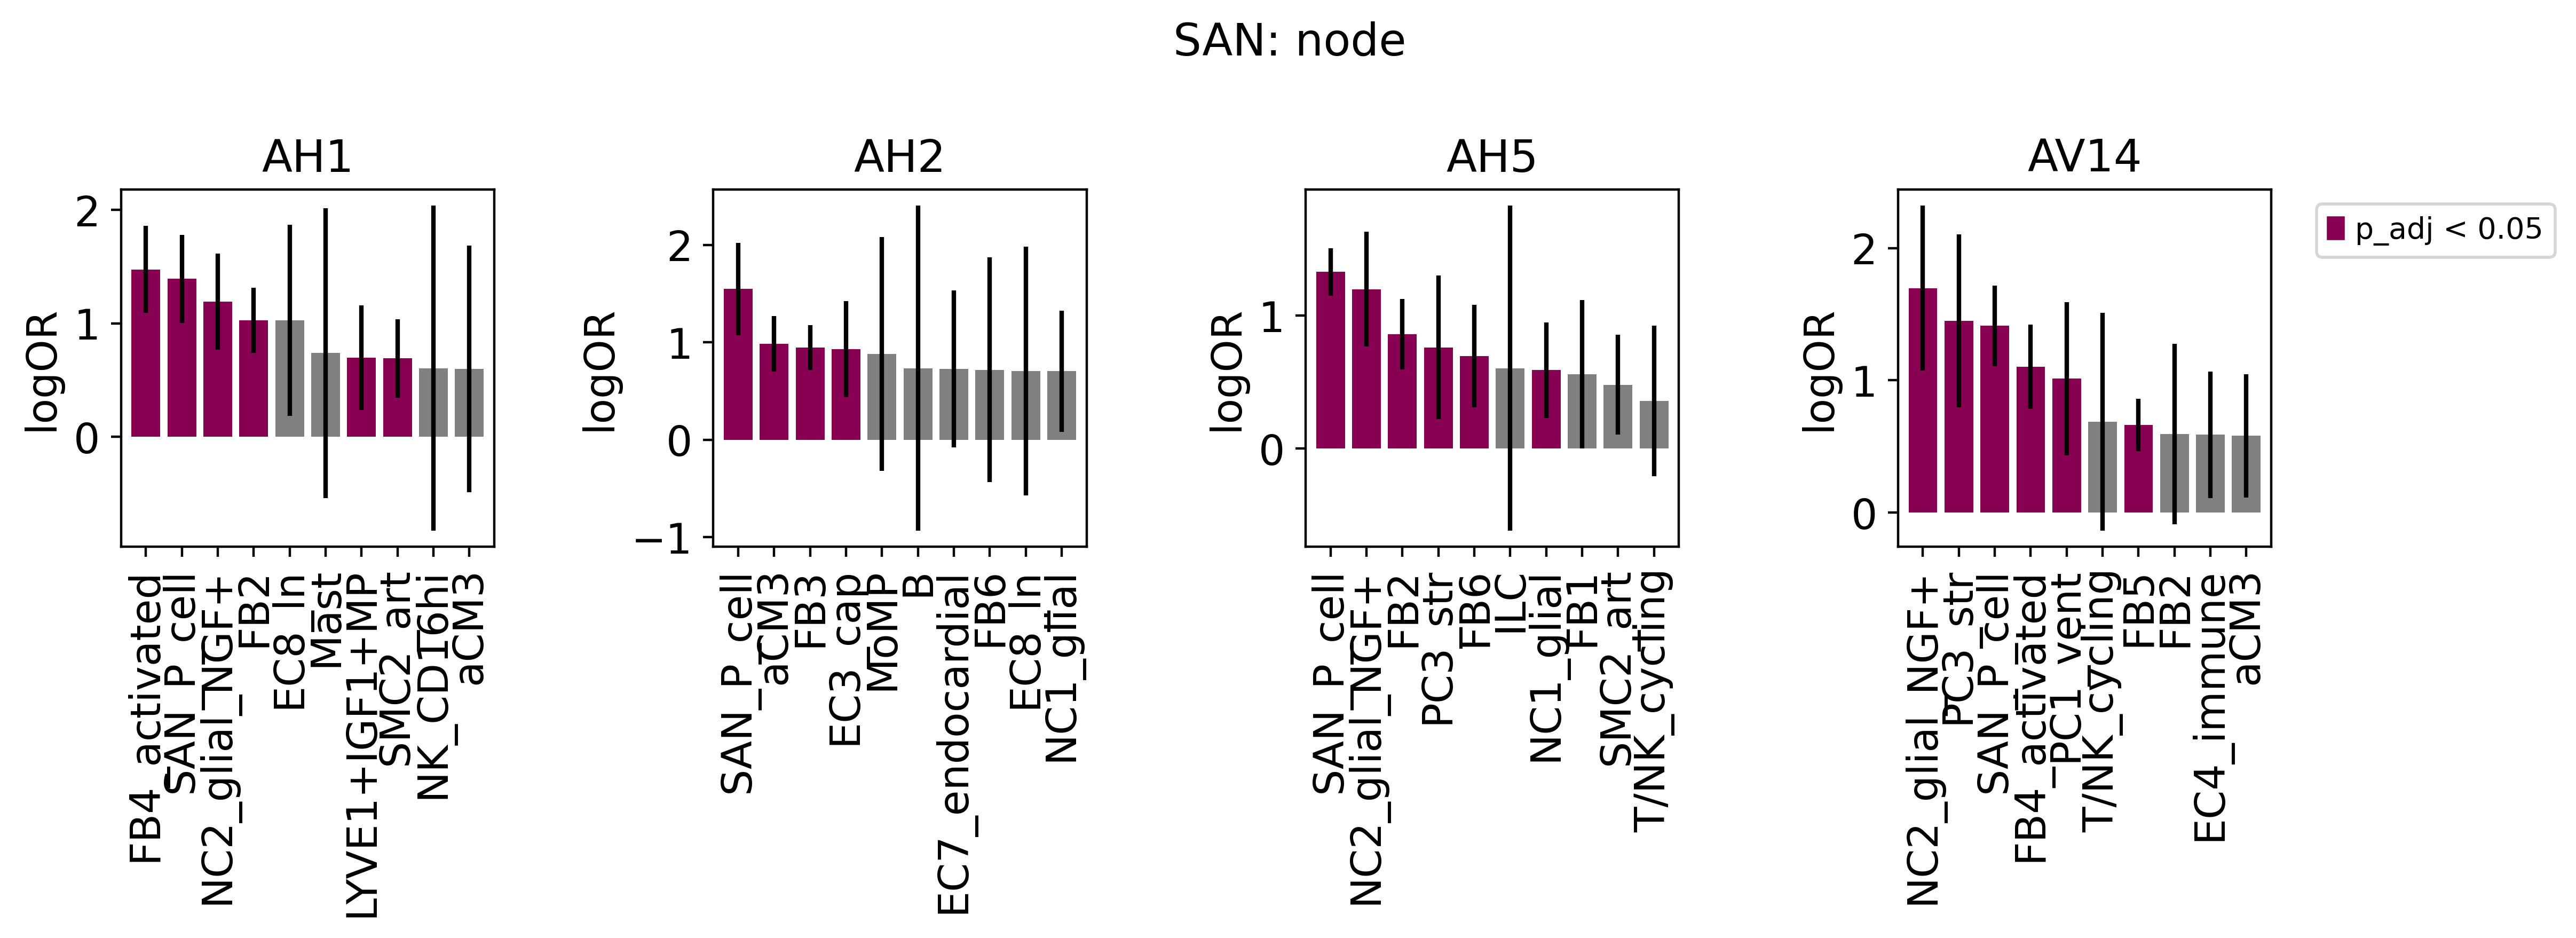

In [42]:
plot_ROIenrichment_bar(adata_vis,
                       region = 'SAN',
                           roi = 'node',
                           # groups = list(set(adata_vis.obs['donor'])), # list
                           groupby='donor',
                           category_name = category_name,
                           filtering = 'rank_pos',  # select from 'rank_pos','pval_pos','rank_both','pval_both'
                           n_rank = 10,
                           p_adj_thresh = 0.05,
                           figsize = (13,4.5),
                       title= 'SAN: node',
                           title_fontsize = 15,
                           legend_fontsize = 10,
                           bbox_to_anchor = (1.8,1),
                       save_fig=True
                          )

/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/ver8regions_torepo/ROIenrichment.py:47: RuntimeWarning: divide by zero encountered in log
  logOR = np.log((roi_target/nonroi_target)/(roi_others/nonroi_others))
/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/ver8regions_torepo/ROIenrichment.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  SE = np.sqrt((1/roi_target)+(1/nonroi_target)+(1/roi_others)+(1/nonroi_others))


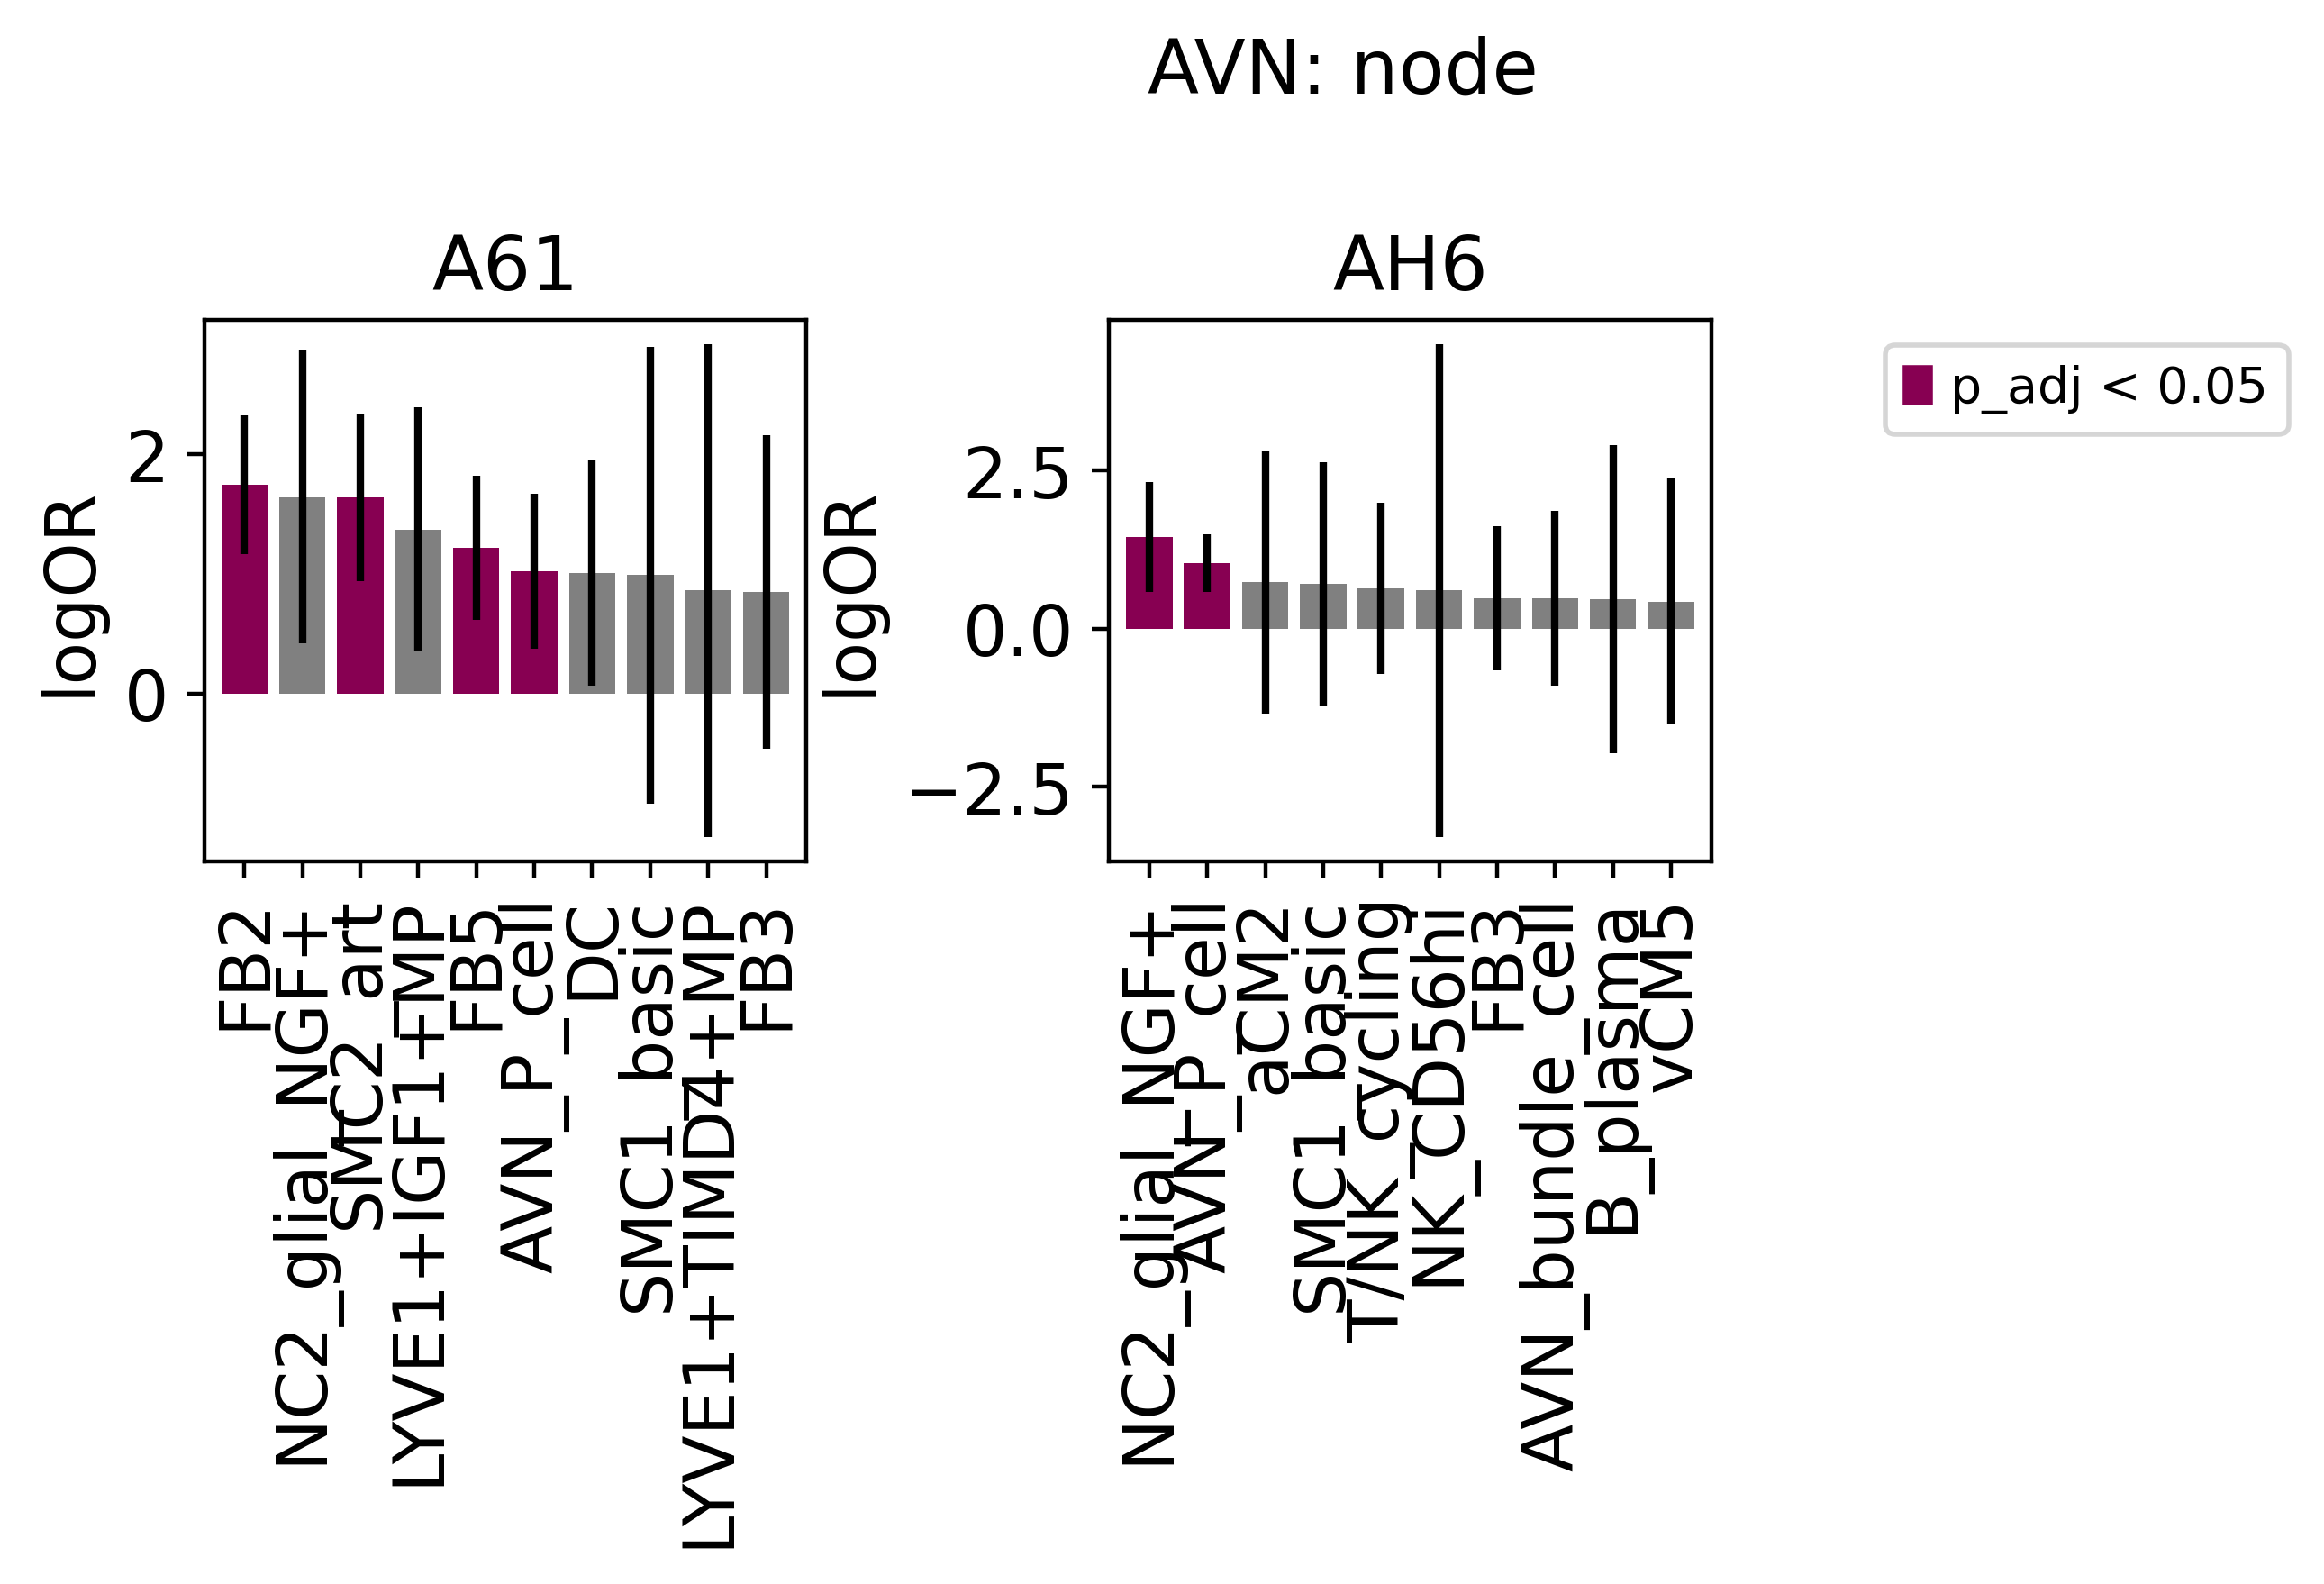

In [44]:
plot_ROIenrichment_bar(adata_vis, 
                       region = 'AVN',
                           roi = 'node',
                           groupby='donor',
                           category_name = category_name,
                           filtering = 'rank_pos',  # select from 'rank_pos','pval_pos','rank_both','pval_both'
                           n_rank = 10,
                           p_adj_thresh = 0.05,
                           figsize = (8,4.5),
                       title= 'AVN: node',
                           title_fontsize = 15,
                           legend_fontsize = 10,
                           bbox_to_anchor = (2,1),
                       save_fig=True
                          )